In [3]:
# ==========================================
# 1. IMPORTACIONES
# ==========================================
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# ==========================================
# 2. DESCARGA DE DATOS DEL DÓLAR (USDCOP)
# ==========================================
# TRM = tasa representativa del mercado (USD vs peso colombiano)
# Usamos 'USDCOP=X' (Yahoo Finance)
data = yf.download("USDCOP=X", start="2015-01-01", end="2025-01-01")

# Verificamos que tenga datos válidos
if data.empty:
    raise ValueError("No se pudieron obtener datos de USDCOP desde Yahoo Finance.")

# Tomaremos la columna 'Close' como la TRM diaria
trm = data['Close'].dropna().values

/tmp/ipykernel_1068257/398052758.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("USDCOP=X", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [8]:
# ==========================================
# 3. CONSTRUCCIÓN DEL DATASET (5 entradas → 1 salida a 7 días)
# ==========================================
X = []
Y = []
for i in range(len(trm) - 12):
    X.append(trm[i:i+5])
    Y.append(trm[i+12])

X = np.array(X)
Y = np.array(Y)

# ✅ Verificar y corregir dimensiones
print("Shape original de X:", X.shape)
X = X.reshape(len(X), -1)  # Asegura que sea 2D
print("Shape corregido de X:", X.shape)

Shape original de X: (2596, 5, 1)
Shape corregido de X: (2596, 5)


In [9]:
# ==========================================
# 4. NORMALIZACIÓN
# ==========================================
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_norm = scaler_X.fit_transform(X)
Y_norm = scaler_Y.fit_transform(Y.reshape(-1, 1)).ravel()

In [10]:
# ==========================================
# 5. CONSTRUCCIÓN DEL MODELO MLP CON KERAS
# ==========================================
num_layers = int(input("Ingrese el número de capas ocultas: "))
neuronas_por_capa = [
    int(input(f"Ingrese el número de neuronas para la capa {i+1}: "))
    for i in range(num_layers)
]

model = keras.Sequential()
model.add(layers.Dense(neuronas_por_capa[0], activation='tanh', input_shape=(5,)))
for n in neuronas_por_capa[1:]:
    model.add(layers.Dense(n, activation='tanh'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/home/david/Documentos/estudios/2025-2 ITM/EII/venv-eii/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-27 01:24:04.779256: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
# ==========================================
# 6. ENTRENAMIENTO
# ==========================================
history = model.fit(X_norm, Y_norm, epochs=200, verbose=1)

Epoch 1/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6468 - mae: 0.7609
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0796 - mae: 0.2388
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - mae: 0.0964
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - mae: 0.0929
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0122 - mae: 0.0921
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 - mae: 0.0913
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 - mae: 0.0903
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - mae: 0.0893
Epoch 9/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - mae: 0.0882
Epoch 10/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - mae: 0.0872
Epoch 11/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - mae: 0.0860
Epoch 12/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - mae: 0.0847
Epoch 13/200
82/82 ━━━━━━━━━━━━━━━━━━

In [12]:
# ==========================================
# 7. PREDICCIÓN SOBRE EL MISMO CONJUNTO (TEST INTERNO)
# ==========================================
Y_pred_norm = model.predict(X_norm)
Y_pred = scaler_Y.inverse_transform(Y_pred_norm)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


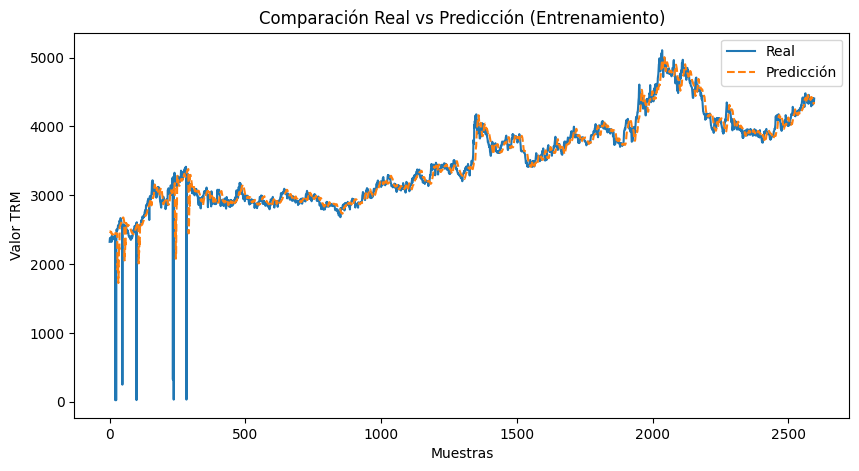

In [13]:
# Gráfico de comparación
plt.figure(figsize=(10, 5))
plt.plot(Y, label="Real")
plt.plot(Y_pred, label="Predicción", linestyle='dashed')
plt.title("Comparación Real vs Predicción (Entrenamiento)")
plt.xlabel("Muestras")
plt.ylabel("Valor TRM")
plt.legend()
plt.show()


==== Predicción personalizada a 7 días ====


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


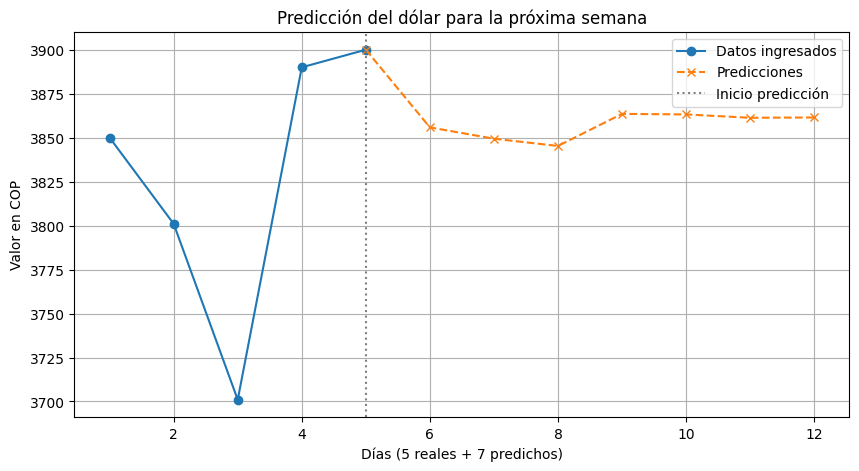


📌 Predicciones para los próximos 7 días:
Día futuro 1: $3,855.85 COP
Día futuro 2: $3,849.40 COP
Día futuro 3: $3,845.29 COP
Día futuro 4: $3,863.52 COP
Día futuro 5: $3,863.21 COP
Día futuro 6: $3,861.31 COP
Día futuro 7: $3,861.48 COP


In [15]:
# ==========================================
# 8. INTERFAZ PARA USUARIO (Predicción 7 días)
# ==========================================
print("\n==== Predicción personalizada a 7 días ====")
nuevo_x = []
for i in range(5):
    val = float(input(f"Ingrese el valor del dólar para el día {i+1}: "))
    nuevo_x.append(val)

# Convertimos a formato adecuado
ventana_actual = np.array(nuevo_x, dtype=np.float32).reshape(1, -1)

# Guardamos los valores originales para graficar
valores_grafica = list(nuevo_x)

# Generamos las 7 predicciones encadenadas
for _ in range(7):
    # Normalizar la ventana de entrada
    ventana_norm = scaler_X.transform(ventana_actual)

    # Predecir 1 día
    pred_norm = model.predict(ventana_norm)
    pred_real = scaler_Y.inverse_transform(pred_norm)[0][0]

    # Agregar al gráfico
    valores_grafica.append(pred_real)

    # Preparar la siguiente ventana deslizante
    nueva_ventana = list(ventana_actual.flatten()[1:]) + [pred_real]
    ventana_actual = np.array(nueva_ventana, dtype=np.float32).reshape(1, -1)

# ==========================================
# 9. GRÁFICA: 5 valores ingresados + 7 predicciones
# ==========================================
import matplotlib.pyplot as plt

dias = list(range(1, 13))  # 5 días reales + 7 predichos

plt.figure(figsize=(10, 5))
plt.plot(dias[:5], valores_grafica[:5], marker='o', label="Datos ingresados")
plt.plot(dias[4:], valores_grafica[4:], marker='x', linestyle='--', label="Predicciones")
plt.axvline(x=5, color='gray', linestyle=':', label="Inicio predicción")

plt.title("Predicción del dólar para la próxima semana")
plt.xlabel("Días (5 reales + 7 predichos)")
plt.ylabel("Valor en COP")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar también los valores en consola
print("\n📌 Predicciones para los próximos 7 días:")
for i, val in enumerate(valores_grafica[5:], start=1):
    print(f"Día futuro {i}: ${val:,.2f} COP")
